# Characterize...

- Experimental branch points
- Test set performance
- Extrapolative performance

In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
L = 70
def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

# Load model

In [4]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [5]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../hg19.pathogenicv2.features.tsv')
benign = read_variants('../../hg19.allgnomad.features.tsv')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Get effect on prediction for variants

In [6]:
def get_features(p):
    X_ref, X_alt, indexes = [], [], []
    for pos, shift, chrom, strand, ref, alt in zip(p['POS'],
                                                   p["3'Dist"],
                                                   p['CHROM'],
                                                   p['strand'],
                                                   p['REF'],
                                                   p['ALT']):
        chrom = 'chr'+str(chrom)
        three = pos + (-shift if strand == '+' else shift-1)
        if strand == '+':
            begin, stop = three - L, three + len(ref) - 1
        else:
            begin, stop = three - len(ref)+1, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X_ref += [onehot(seq[-70:]).reshape(1, 70, 4)]
        indexes += [L+shift-1]

        altseq = (seq[:indexes[-1]]
                  + (alt if strand == '+' else genome.revcomp(alt))
                  + seq[indexes[-1]+len(ref):])
        X_alt += [onehot(altseq[-70:]).reshape(1, 70, 4)]

    return np.vstack(X_ref), np.vstack(X_alt), np.array(indexes)

def get_stats(ref, alt, indexs):
    old = []
    new = []
    for r, a in zip(ref, alt):
        bp = np.argmax(r)
        old += [a[bp] - r[bp]]
        bp = np.argmax(a)
        new += [a[bp] - r[bp]]
    old = np.array(old)
    new = np.array(new)
    max_delta = np.max(alt, axis = 1) - np.max(ref, axis = 1)
    shift = indexs - np.argmax(ref, axis =1)
    return shift, old, new, max_delta

In [8]:
p = pathogenic[(pathogenic["3'Dist"] > -45) & (pathogenic["3'Dist"] <= -18)]

path_X_ref, path_X_alt, path_indexes = get_features(p)

path_shift, path_delta, path_gain, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                              model.predict(path_X_alt).reshape(-1, L),
                                                              path_indexes)

b = benign[(benign["3'Dist"] > -45) & (benign["3'Dist"] <= -18)][:1000]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_gain, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                                      model.predict(benign_X_alt).reshape(-1, L),
                                                                      benign_indexes)

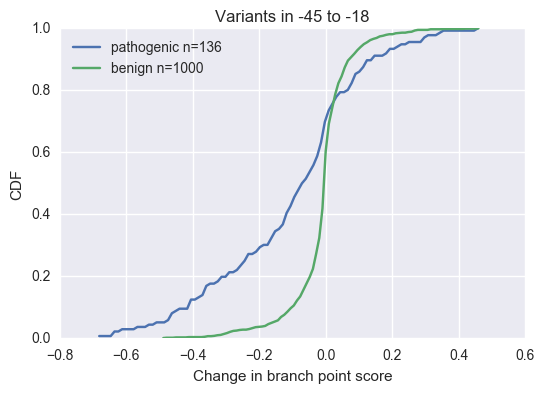

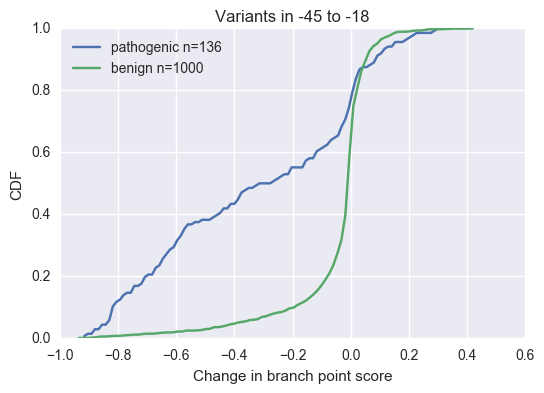

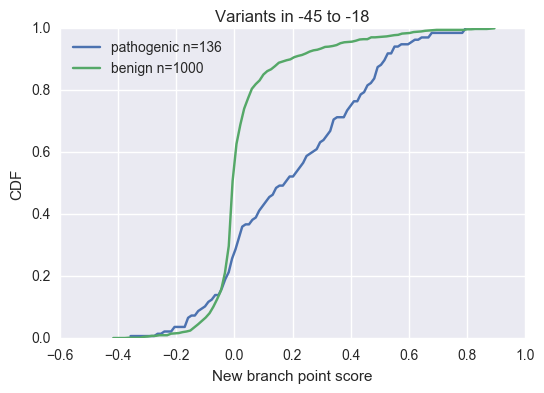

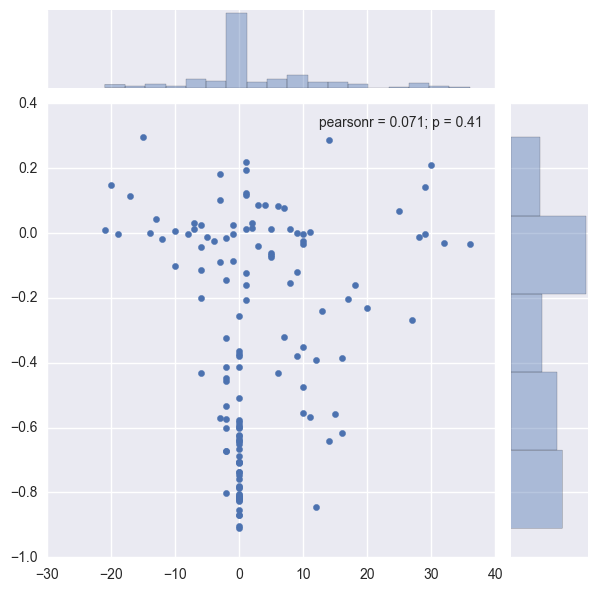

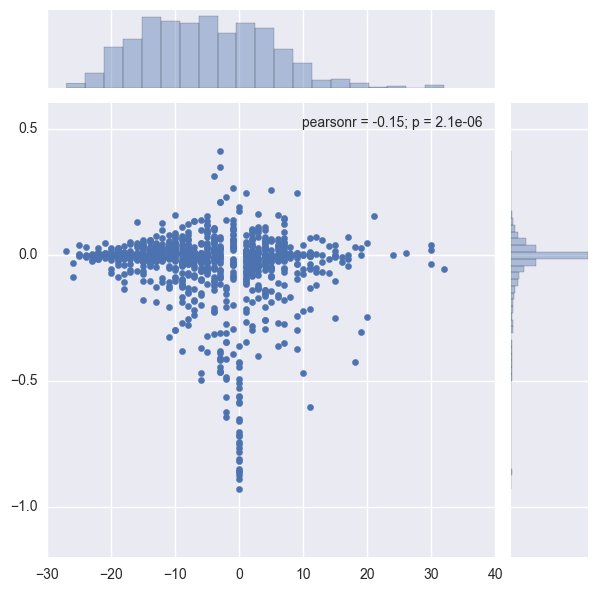

In [9]:

sns.jointplot(path_shift,from scipy.stats import cumfreq
def cdf(a, label, bins = 100):
    c = cumfreq(a, bins)
    lower = c.lowerlimit
    upper = lower + bins * c.binsize
    plt.plot(np.linspace(lower, upper, bins),
             c.cumcount / a.shape[0],
             label = label)
    
def compare_cdfs(path, benign, title, xlabel):
    cdf(path, "pathogenic n={}".format(path.shape[0]))
    cdf(benign, "benign n={}".format(benign.shape[0]))
    plt.legend()
    plt.ylabel('CDF')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()
    
compare_cdfs(path_max_delta, benign_max_delta, 'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_delta, benign_delta, 'Variants in -45 to -18', 'Change in branch point score')
compare_cdfs(path_gain, benign_gain, 'Variants in -45 to -18', 'New branch point score') path_delta)
sns.jointplot(benign_shift, benign_delta)

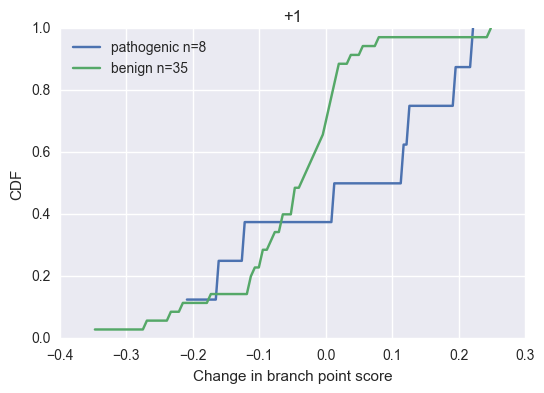

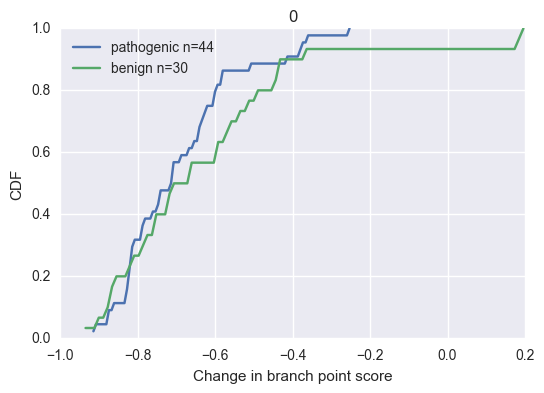

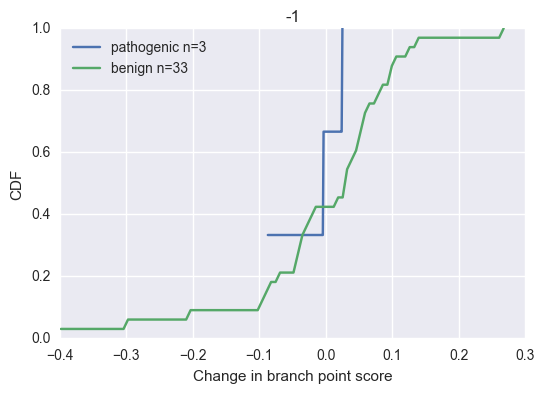

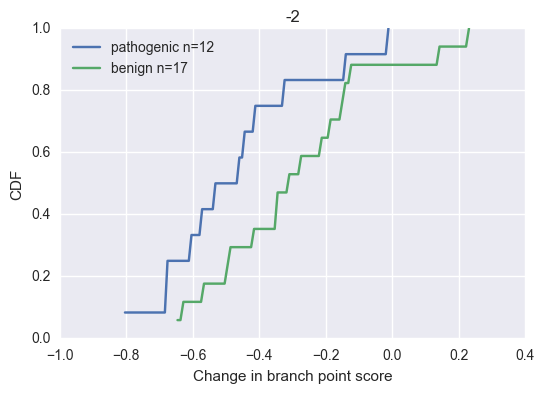

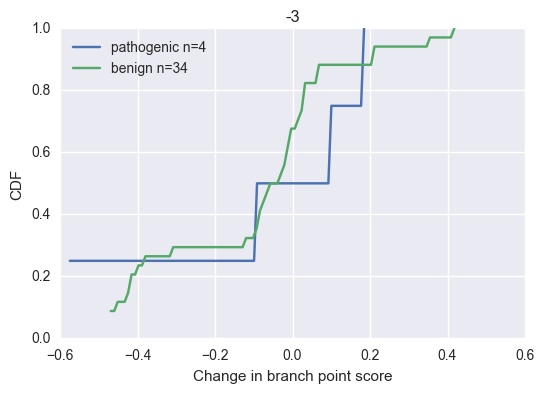

In [10]:
compare_cdfs(path_delta[path_shift == 1], benign_delta[benign_shift == 1], '+1', 'Change in branch point score')
compare_cdfs(path_delta[path_shift == 0], benign_delta[benign_shift == 0], '0', 'Change in branch point score')
compare_cdfs(path_delta[path_shift == -1], benign_delta[benign_shift == -1], '-1', 'Change in branch point score')
compare_cdfs(path_delta[path_shift == -2], benign_delta[benign_shift == -2], '-2', 'Change in branch point score')
compare_cdfs(path_delta[path_shift == -3], benign_delta[benign_shift == -3], '-3', 'Change in branch point score')

# For use in pathogenicity predictor

In [12]:
p = pathogenic[(pathogenic["3'Dist"] > -50) & (pathogenic["3'Dist"] <= -6)]

path_X_ref, path_X_alt,  path_indexes = get_features(p)

path_shift, path_delta, path_gain, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                   model.predict(path_X_alt).reshape(-1, L),
                                                   path_indexes)

b = benign[(benign["3'Dist"] > -50) & (benign["3'Dist"] <= -6)]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_gain, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                         model.predict(benign_X_alt).reshape(-1, L),
                                                         benign_indexes)

In [15]:
with open('../../pathv2.bp.txt', 'w') as fp:
    for chrom, pos, pred in zip(p['CHROM'], p['POS'], path_delta):
        fp.write('\t'.join([str(chrom), str(pos), str(pred)])+'\n')
        
with open('../../benignv2.bp.txt', 'w') as fp:
    for chrom, pos, pred in zip(b['CHROM'], b['POS'], benign_delta):
        fp.write('\t'.join([str(chrom), str(pos), str(pred)])+'\n')